# Forecast Cases

Using a generative model, simulate the number of infectious individuals to forecast at National and State level.

We have three types of infectious individuals: Imported $\left(I_{I}\right),$ Asymptomatic $\left(I_{A}\right),$ and Symptomatic $\left(I_{S}\right)$
- Each case is assumed to generate a number of cases from a Negative Binomial distribution, with parameters $k$ and, respectively, $\alpha_{I} R_{\mathrm{eff}} /\left(\alpha_{I} R_{\mathrm{eff}}+k\right), \alpha_{A} R_{\mathrm{eff}} /\left(\alpha_{A} R_{\mathrm{eff}}+k\right)$ and $\alpha_S R_{\mathrm{eff}} /\left(\alpha_S R_{\mathrm{eff}}+k\right)$
- The parameter $k$ is the shape parameter of an Erlang infectious period; we will likely fix this at $k=3$ (but can try a few values)
$-$ The parameters $\alpha_{I}$ and $\alpha_{A}$ correspond to the reduced transmissibility of, respectively, imported and asymptomatic cases. Perhaps we want to infer these, but prior (and initial distribution for generation might be $\operatorname{Beta}(a, b)$ with mean 0.1 and low variance.
$-$ The parameter $R_{\mathrm{eff}}$ can be sampled from David's estimates, or Dennis's model.
- New infectious indviduals generated as above are assigned to be Symptomatic with probability $p_{S}$ and are otherwise Asymptomatic.
$-$ We might try to infer $p_{S},$ but to start with we might have $p_{S} \sim \operatorname{Beta}(c, d)$ such that the mean is 0.5 and variance such that it is reasonably confidently between 0.25 and 0.75
- Infectious individuals are detected, and hence become a case, with respective probabilities $q_{I}, q_{A}$ and $q_{S}$ respectively.
$-$ We might try to infer these, but to start with I think $q_{A} \sim \operatorname{Beta}(e, f)$ such that the mean is 0.001 and low variance, $q_{I}, q_{S} \sim \operatorname{Beta}(g, h)$ such that the mean is 0.9 and low variance.
- For each infectious individual, we generate the time that they became infected by adding to the time of infection of their parent a random time generated from a Gamma(mean $=i,$ variance $=j$ ) distribution.
$-$ We probably want to infer $i$ and $j,$ but to start I think $i=5$ and a reasonably large variance.
For those that are detected, we also need to add on to their time of infection the delay until they are detected (which rounded, gives the day they appear in the case data), generated from a Gamma(mean= $k$, variance $=l$ ) distribution.
$-$ We probably want to infer $k$ and $l,$ but to start I think $k=6$ and a large (but not as large as infection distribution above)
- We additionally have a $\operatorname{Poi}\left(\iota_{t}\right)$ number of new imported infectious individuals on day $t,$ where $\iota_{t}$ decreases in time, especially from quarantine restrictions, and to be inferred from data.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import nbinom, erlang, beta, binom, gamma, poisson, beta
import matplotlib.pyplot as plt
import os
class Person:
    """
    Individuals in the forecast
    """
    # Laura
    # default action_time to 0. This allows for code that doesn’t involve contact tracing (undetected cases) 
    # to continue without modification.
    def __init__(self,parent, infection_time,detection_time, detected,category:str, action_time = 0):
        """
        Category is one of 'I','A','S' for Imported, Asymptomatic and Symptomatic
        """
        self.parent = parent
        self.infection_time = infection_time
        self.detection_time = detection_time
        self.detected = detected
        self.category = category
        # Laura
        # Add action time to Person object
        self.action_time = action_time
    
class Forecast:
    """
    Forecast object that contains methods to simulate a forcast forward, given Reff and current state.
    """
    
    def __init__(self,current, state,start_date, people, 
        Reff=2.2,k=0.1,alpha_i=1,gam_list=[0.8],qi_list=[1], qa_list=[1/8], qs_list=[0.8],
        qua_ai= 1, qua_qi_factor=1, qua_qs_factor=1,forecast_R=None,R_I=None,
        forecast_date='2020-07-01', cross_border_state=None,cases_file_date=('25Jun','0835'),
        ps_list=[0.7], test_campaign_date=None, test_campaign_factor=1,
        Reff_file_date=None,
        ):
        import numpy as np
        self.initial_state = current.copy() #Observed cases on start day
        #self.current=current
        self.state = state
        #start date sets day 0 in script to start_date
        self.start_date = pd.to_datetime(start_date,format='%Y-%m-%d')
        self.quarantine_change_date = pd.to_datetime(
            '2020-04-01',format='%Y-%m-%d').dayofyear - self.start_date.dayofyear
        self.initial_people = people.copy() #detected people only
        self.Reff = Reff
        self.alpha_i = alpha_i
        self.gam_list = gam_list
        self.ps_list = ps_list#beta.rvs(7,3,size=1000)
        self.qi_list = qi_list
        self.qa_list = qa_list
        self.qs_list = qs_list
        self.k = k
        self.qua_ai = qua_ai
        self.qua_qi_factor = qua_qi_factor
        self.qua_qs_factor=qua_qs_factor

        self.forecast_R = forecast_R
        self.R_I = R_I
        np.random.seed(1)
        #self.max_cases = 100000

        self.forecast_date = pd.to_datetime(
            forecast_date,format='%Y-%m-%d').dayofyear - self.start_date.dayofyear

        self.Reff_file_date = Reff_file_date
        self.cross_border_state = cross_border_state
        self.cases_file_date = cases_file_date

        if self.cross_border_state is not None:
            self.travel_prob = self.p_travel()
            self.travel_cases_after = 0
            #placeholders for run_state script 
            self.cross_border_seeds = np.zeros(shape=(1,2),dtype=int)
            self.cross_border_state_cases = np.zeros_like(self.cross_border_seeds)

        if test_campaign_date is not None:
            self.test_campaign_date = pd.to_datetime(
                test_campaign_date,format='%Y-%m-%d').dayofyear - self.start_date.dayofyear
            self.test_campaign_factor = test_campaign_factor
        else:
            self.test_campaign_date = None
        #import model parameters
        self.a_dict = {
            'ACT': {
                1:2,
                2:22,
                3:31*1.3,
                4:17,
                5:15,
                6:3,
            },
            'NSW': {
                1: 90,
                2: 408,
                3: 694*1.3,
                4: 380,
                5: 312,
                6: 276,
            },
            'NT': {
                1: 3,
                2: 4,
                3: 7*1.3,
                4: 9,
                5: 6,
                6: 4,
            },
            'QLD': {
                1:61,
                2:190,
                3:305*1.3,
                4:162,
                5:87,
                6:25,
            },
            'SA': {
                1:13,
                2:68,
                3:115*1.3,
                4:67,
                5:27,
                6:6
            },
            'TAS':{
                1:6,
                2:14,
                3:32*1.3,
                4:19,
                5:11,
                6:2,
            },
            'VIC': {
                1:62,
                2:208,
                3:255*1.3,
                4:157,
                5:87,
                6:188,
            },
            'WA': {
                1:15,
                2:73,
                3:154*1.3,
                4:115,
                5:110,
                6:78
            },
        }
        #changes below also need to be changed in simulate
        self.b_dict = {
            1: 6.2,
            2: 7.2,
            3: 5.2,
            4: 5.2,
            5: 22.2,
            6: 145.2 ## this needs to change for
                    # each change in forecast date
        }

        dir_path = os.getcwd()
        self.datapath = os.path.join(dir_path,'../../data/')


        assert len(people) == sum(current), "Number of people entered does not equal sum of counts in current status"
        
    def generate_times(self,  i=2.5, j=1.25, m=1.2, n=1, size=10000):
        """
        Generate large amount of gamma draws to save on simulation time later
        """

        self.inf_times = 1 + np.random.gamma(i/j, j, size =size) #shape and scale
        self.detect_times = 1 + np.random.gamma(m/n,n, size = size)

        return None
    

    def iter_inf_time(self):
        """
        access Next inf_time
        """
        from itertools import cycle
        for time in cycle(self.inf_times):
            yield time
    
    def iter_detect_time(self):
        """
        access Next detect_time
        """
        from itertools import cycle
        for time in cycle(self.detect_times):
            yield time

    def initialise_sim(self,curr_time=0):
        """
        Given some number of cases in self.initial_state (copied),
        simulate undetected cases in each category and their 
        infectious times. Updates self.current for each person.
        """
        from math import ceil
        if curr_time ==0:
            
            #grab a sample from parameter lists
            self.qs = self.choose_random_item(self.qs_list)
            self.qa = self.choose_random_item(self.qa_list)
            #resample qa until it is less than self.qs
            while self.qa>=self.qs:
                self.qa = self.choose_random_item(self.qa_list)
            self.qi = self.choose_random_item(self.qi_list)
            self.gam = self.choose_random_item(self.gam_list)
            
            self.ps = self.choose_random_item(self.ps_list)
            self.alpha_s = 1/(self.ps + self.gam*(1-self.ps))
            self.alpha_a = self.gam * self.alpha_s
            self.current = self.initial_state.copy()
            self.people = self.initial_people.copy()

            #N samples for each of infection and detection times
            #Grab now and iterate through samples to save simulation
            self.generate_times(size=10000)
            self.get_inf_time = self.iter_inf_time()
            self.get_detect_time = self.iter_detect_time()

            #counters for terminating early
            self.inf_backcast_counter = 0
            self.inf_forecast_counter = 0

            #assign infection time to those discovered
            # obs time is day =0
            for person in self.people.keys():
                self.people[person].infection_time = -1*next(self.get_inf_time)
        else:
            #reinitialising, so actual people need times
            #assume all symptomatic
            prob_symp_given_detect = self.qs*self.ps/(
                self.qs*self.ps + self.qa*(1-self.ps)
            )
            num_symp = binom.rvs(n=int(self.current[2]), p=prob_symp_given_detect)
            for person in range(int(self.current[2])):
                self.infected_queue.append(len(self.people))
                
                inf_time = next(self.get_inf_time)
                detection_time = next(self.get_detect_time)
                if person <- num_symp:
                    new_person = Person(-1, 
                    curr_time-1*detection_time ,
                    curr_time, 1, 'S')
                else:
                    new_person = Person(-1, 
                    curr_time-1*detection_time ,
                    curr_time, 1, 'A')
                
                self.people[len(self.people)] = new_person
                
                #self.cases[max(0,ceil(new_person.infection_time)), 2] +=1
                

        #num undetected is nbinom (num failures given num detected)
        if self.current[2]==0:
            num_undetected_s = nbinom.rvs(1,self.qs*self.qua_qs_factor)
        else:
            num_undetected_s = nbinom.rvs(self.current[2],self.qs*self.qua_qs_factor)
        
        if self.current[0]==0:
            num_undetected_i = nbinom.rvs(1,self.qs*self.qua_qs_factor)
        else:
            num_undetected_i = nbinom.rvs(self.current[0], self.qi*self.qua_qi_factor)

        total_s = num_undetected_s + self.current[2]

        #infer some non detected asymp at initialisation
        if total_s==0:
            num_undetected_a = nbinom.rvs(1, self.ps)
        else:
            num_undetected_a = nbinom.rvs(total_s, self.ps)

        #simulate cases that will be detected within the next week
        #for n in range(1,8):
            #just symptomatic?
            #self.people[len(self.people)] = Person(0, -1*next(self.get_inf_time) , n, 0, 'S')
        if curr_time==0:
            #Add each undetected case into people
            for n in range(num_undetected_i):
                self.people[len(self.people)] = Person(0, curr_time-1*next(self.get_inf_time) , 0, 0, 'I')
                self.current[0] +=1
            for n in range(num_undetected_a):
                self.people[len(self.people)] = Person(0, curr_time-1*next(self.get_inf_time) , 0, 0, 'A')
                self.current[1] +=1
            for n in range(num_undetected_s):
                self.people[len(self.people)] = Person(0, curr_time-1*next(self.get_inf_time) , 0, 0, 'S')
                self.current[2] +=1
        else:
            #reinitialised, so add these cases back onto cases
             #Add each undetected case into people
            for n in range(num_undetected_i):
                new_person = Person(-1, curr_time-1*next(self.get_inf_time) , 0, 0, 'I')
                self.infected_queue.append(len(self.people))
                self.people[len(self.people)] = new_person
                self.cases[max(0,ceil(new_person.infection_time)),0] +=1
            for n in range(num_undetected_a):
                new_person = Person(-1, curr_time-1*next(self.get_inf_time) , 0, 0, 'A')
                self.infected_queue.append(len(self.people))
                self.people[len(self.people)] = new_person
                self.cases[max(0,ceil(new_person.infection_time)),1] +=1
            for n in range(num_undetected_s):
                new_person = Person(-1, curr_time-1*next(self.get_inf_time) , 0, 0, 'S')
                self.infected_queue.append(len(self.people))
                self.people[len(self.people)] = new_person
                self.cases[max(0,ceil(new_person.infection_time)),2] +=1
            
        return None

    def read_in_Reff(self):
        """
        Read in Reff csv from Price et al 2020. Originals are in RDS, are converted to csv in R script
        """
        import pandas as pd
        #df= pd.read_csv(self.datapath+'R_eff_2020_04_23.csv', parse_dates=['date'])
        if self.cross_border_state is not None:
            states = [self.state,self.cross_border_state]
        else:
            states=[self.state]
        

        if self.forecast_R is not None:
            if self.Reff_file_date is None:
                import glob, os

                list_of_files = glob.glob(self.datapath+'soc_mob_R*.h5') 
                latest_file = max(list_of_files, key=os.path.getctime)
                print("Using file "+latest_file)
                df_forecast = pd.read_hdf(latest_file,
            key='Reff')
            else:
                df_forecast = pd.read_hdf(self.datapath+'soc_mob_R'+self.Reff_file_date+'.h5',
            key='Reff')
            num_days = df_forecast.loc[
                (df_forecast.type=='R_L')&(df_forecast.state==self.state)].shape[0]
            if self.R_I is not None:
                self.R_I = df_forecast.loc[
                    (df_forecast.type=='R_I')&
                    (df_forecast.state==self.state),
                    [i for i in range(1000)]].values[0,:]

            #R_L here 
            df_forecast = df_forecast.loc[df_forecast.type==self.forecast_R]

            #df = pd.concat([
            #            df.drop(['type','date_onset','confidence',
            #                 'bottom','top','mean_window','prob_control',
            #                'sd_window'],axis=1),
            #            df_forecast.drop(['type'],axis=1)
            #                ])
            
           #df = df.drop_duplicates(['state','date'],keep='last')
            df = df_forecast
            df = df.set_index(['state','date'])
        
        Reff_lookupdist ={}

        for state in states:
            Reff_lookupstate = {}
            if self.forecast_R =='R_L':
                dfReff_dict = df.loc[state,[0,1]].to_dict(orient='index')

                for key, stats in dfReff_dict.items():
                    #instead of mean and std, take all columns as samples of Reff
                    #convert key to days since start date for easier indexing
                    newkey = key.dayofyear - self.start_date.dayofyear

                    Reff_lookupstate[newkey] = df.loc[(state,key),
                    [i for i in range(1000)]].values

            else:
                #R_L0
                for day in range(num_days):
                    Reff_lookupstate[day] = df.loc[state, [i for i in range(1000)]].values[0]


            #Nested dict with key to state, then key to date
            Reff_lookupdist[state] = Reff_lookupstate

        if self.cross_border_state is not None:
            self.Reff_travel = Reff_lookupdist[self.cross_border_state]
        
        self.Reff = Reff_lookupdist[self.state]
        return None
    
    def choose_random_item(self, items,weights=None):
        from numpy.random import random
        if weights is None:
            #Create uniform weights
            weights = [1/len(items)] * len(items)
        r = random()
        for i,item in enumerate(items):
            r-= weights[i]
            if r <0:
                return item
        
            
    def new_symp_cases(self,num_new_cases:int):
        """
        Given number of new cases generated, assign them to symptomatic (S) with probability ps
        """
        #repeated Bernoulli trials is a Binomial (assuming independence of development of symptoms)
        
        symp_cases = binom.rvs(n=num_new_cases, p=self.ps)

        return symp_cases
    
    def generate_new_cases(self,parent_key, Reff,k,travel=True):
        """
        Generate offspring for each parent, check if they travel
        """
        
        from math import ceil
        from numpy.random import random

    #check parent category   
        if self.people[parent_key].category=='S':
            num_offspring = nbinom.rvs(n=k,p= 1- self.alpha_s*Reff/(self.alpha_s*Reff + k))
        elif self.people[parent_key].category=='A':
            num_offspring = nbinom.rvs(n=k, p = 1- self.alpha_a*Reff/(self.alpha_a*Reff + k))
        else:
            #Is imported
            if self.R_I is not None:
                #if splitting imported from local, change Reff to R_I 
                Reff = self.choose_random_item(self.R_I)
            if self.people[parent_key].infection_time < self.quarantine_change_date:
                #factor of 3 times infectiousness prequarantine changes

                num_offspring = nbinom.rvs(n=k, p = 1- self.qua_ai*Reff/(self.qua_ai*Reff + k))
            else:
                num_offspring = nbinom.rvs(n=k, p = 1- self.alpha_i*Reff/(self.alpha_i*Reff + k))
        
        if num_offspring >0:  
            
            num_sympcases = self.new_symp_cases(num_offspring)
            if self.people[parent_key].category=='A':
                child_times = []
            for new_case in range(num_offspring):
                #define each offspring
                
                inf_time = self.people[parent_key].infection_time + next(self.get_inf_time)
               # LAURA
                # print(inf_time)
                # print(self.forecast_date)
                
                # Laura
                # add an action_time = 0 when an offspring is first examined:
                action_time = 0

                if inf_time > self.forecast_date:
                    self.inf_forecast_counter +=1
                    if travel:
                        if self.cross_border_state is not None:
                        #check if SA person
                            if random() < self.travel_prob:
                                if ceil(inf_time) <= self.cases.shape[0]:
                                    self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] += 1
                                    detection_rv = random()
                                    detect_time = 0 #give 0 by default, fill in if passes
                            
                                    recovery_time = 0 #for now not tracking recoveries
                        
                                    if new_case <= num_sympcases-1: #minus 1 as new_case ranges from 0 to num_offspring-1 
                                        #first num_sympcases are symnptomatic, rest are asymptomatic
                                        category = 'S'                                 
                                        if detection_rv < self.qs:
                                            #case detected
                                            detect_time = inf_time + next(self.get_detect_time)

                                    else:
                                        category = 'A'
                                        detect_time = 0
                                        if detection_rv < self.qa:
                                            #case detected
                                            detect_time = inf_time + next(self.get_detect_time)
                                    self.people[len(self.people)] = Person(parent_key, inf_time, detect_time,recovery_time, category)
                                    self.cross_border_sim(len(self.people)-1,ceil(inf_time))
                                    #skip simulating this offspring in VIC
                                    #continue
                                else:
                                    #cross border seed happened after forecast
                                    self.travel_cases_after +=1
                else:
                    self.inf_backcast_counter +=1
                #normal case within state
                if self.people[parent_key].category=='A':
                    child_times.append(ceil(inf_time))
                if ceil(inf_time) > self.cases.shape[0]:
                    #new infection exceeds the simulation time, not recorded
                    self.cases_after = self.cases_after + 1                
                else:
                    #within forecast time
                    detection_rv = random()
                    detect_time = inf_time + next(self.get_detect_time)
                        
                    isdetected = 0 
                    
                    if new_case <= num_sympcases-1: #minus 1 as new_case ranges from 0 to num_offspring-1 
                        #first num_sympcases are symnptomatic, rest are asymptomatic
                        category = 'S'
                        self.cases[max(0,ceil(inf_time)-1),2] += 1
                        
                        if self.test_campaign_date is not None:
                            #see if case is during a testing campaign
                            if inf_time <self.test_campaign_date:
                                detect_prob = self.qs
                            else:
                                detect_prob = min(0.95,self.qs*self.test_campaign_factor)
                        else:
                            detect_prob = self.qs
                        if detection_rv < detect_prob:
                            #case detected
                            isdetected=1
                            # Laura
                            # if parent is undetected, assign a new time to action 
                            if self.people[parent_key].detected==0:
                                action_time = detect_time + gamma(t_a_shape,t_a_scale)
                            if detect_time < self.cases.shape[0]:
                                self.observed_cases[max(0,ceil(detect_time)-1),2] += 1

                    else:
                        category = 'A'
                        self.cases[max(0,ceil(inf_time)-1),1] += 1
                        #detect_time = 0
                        if self.test_campaign_date is not None:
                        #see if case is during a testing campaign
                            if inf_time <self.test_campaign_date:
                                detect_prob = self.qa
                            else:
                                detect_prob = min(0.95,self.qa*self.test_campaign_factor)
                        else:
                            detect_prob=self.qa
                        if detection_rv < detect_prob:
                            #case detected
                            isdetected=1
                            #detect_time = inf_time + next(self.get_detect_time)
                            # Laura 
                            # Get absolute action time, 
                            # if parent is not detected, assign an action time 
                            # action_time = self.people[parent_key].detection_time + 
                            # 2* draw from distrubtion
                            if self.people[parent_key].detected==0:
                                action_time = detect_time + 2*gamma(t_a_shape,t_a_scale)
                            if detect_time < self.cases.shape[0]:
                                self.observed_cases[max(0,ceil(detect_time)-1),1] += 1

                    # Laura 
                    #add new infected to queue
                    # contact trace 2=1 day before parent's detection time
                    if self.people[parent_key].detected==1:
                        #only check contact tracing if parent was detected
                        
                        if inf_time < self.people[parent_key].detection_time - DAYS:
                            
                            self.infected_queue.append(len(self.people))
                            
                        #elif  (self.people[parent_key].detection_time - DAYS) < inf_time < (self.people[parent_key].action_time):
                        # elif ((self.people[parent_key].detection_time - DAYS) < inf_time) and (inf_time < (self.people[parent_key].action_time)):   
                        elif inf_time < (self.people[parent_key].action_time):   
                            
                            x_rn = random()
                            if x_rn <= p_c:
                        
                                action_time = self.people[parent_key].action_time
                                self.infected_queue.append(len(self.people))
                            
                        # else assign new time to action.
                        # need to add if de
                            else:
                                action_time = inf_time + gamma(t_a_shape,t_a_scale)
                                self.infected_queue.append(len(self.people))
                                
                    else:
                        #parent undetected
                        self.infected_queue.append(len(self.people))
                        

                    #add person to tracked people
                    # Laura # add action_time when recording
                    self.people[len(self.people)] = Person(parent_key, inf_time, detect_time,isdetected, category,action_time)

            if travel:
                #for parent, check their cross border travel
                if self.cross_border_state is not None:
                    #Run cross border sim across children
                    inf_time = self.people[parent_key].infection_time

                    detect_time = self.people[parent_key].detection_time

                    if self.people[parent_key].infection_time>self.forecast_date:
                        #check it is after forecast date but before
                        #end date
                        if ceil(inf_time)-1 < self.cases.shape[0]:
                            #check if travel
                            #symptomatic people here
                            pre_symp_time = inf_time
                            while pre_symp_time < detect_time:
                                travel_rv = random()
                                if travel_rv<self.travel_prob:
                                    #travelled
                                    ## did they infect?
                                    #symptomatic
                                    self.cross_border_sim(parent_key,ceil(pre_symp_time))

                                #can travel more than once
                                pre_symp_time +=1 #move forward a day
                                if pre_symp_time>self.cases.shape[0]:
                                    break
                            if detect_time==0:
                                #asymptomatics
                                if self.people[parent_key].category=='A':
                                    for pre_symp_time in child_times:
                                        if pre_symp_time< self.cases.shape[0] -1:
                                            #only care if still within forecast time
                                            travel_rv = random()
                                            if travel_rv<self.travel_prob:
                                            #travelled
                                            ## did they infect?
                                                self.cross_border_sim(parent_key,ceil(pre_symp_time))

                                            #remove case from original state?
        return None
    
    def cases_detected(self,new_cases):
        """
        Given a tuple of new_cases generated, return the number of cases detected
        """
        #Number of detected cases in each class is Binomial with p = q_j

        i_detected = binom.rvs(n=new_cases[0],p=self.qi)
        a_detected = binom.rvs(n=new_cases[1],p=self.qa)
        s_detected = binom.rvs(n=new_cases[2],p=self.qs)

        return i_detected, a_detected, s_detected
    
    def import_arrival(self,period,size=1):
        """
        Poisson likelihood of arrivals of imported cases, with a Gamma
        prior on the mean of Poisson, results in a posterior predictive
        distribution of imported cases a Neg Binom
        """
        a = self.a_dict[self.state][period]
        b = self.b_dict[period]
        if size==1:
            return nbinom.rvs(a, 1-1/(b+1))
        else:
            return nbinom.rvs(a, 1-1/(b+1),size=size)

    def simulate(self, end_time,sim,seed):
        """
        Simulate forward until end_time
        """
        from collections import deque
        from math import ceil
        import gc
        np.random.seed(seed)
        self.num_of_sim = sim
        #generate storage for cases
        self.cases = np.zeros(shape=(end_time, 3),dtype=float)
        self.observed_cases = np.zeros_like(self.cases)
        
        self.observed_cases[0,:] = self.initial_state.copy()

        #Initalise undetected cases and add them to current
        self.initialise_sim()
        #number of cases after end time
        self.cases_after = 0 #gets incremented in generate new cases

        #Record day 0 cases
        self.cases[0,:] = self.current.copy() 
        # Generate imported cases
        num_days={
            1: 6,
            2: 8,
            3: 4,
            4: 5,
            5: 22,#min(end_time - self.quarantine_change_date -7, 24 ),
            6: max(0,end_time- 6-8-4-5-22),
        }
        qi = {
            1:self.qi *self.qua_qi_factor,
            2:self.qi,
            3:self.qi,
            4:0.95,
            5:0.98,
            6:0.98,
        }
        new_imports = []
        unobs_imports =[]
        for period in range(1,7): 
            ##ADDED continue TO SKIP THIS FOR LB
            continue
            ######
            obs_cases = self.import_arrival(
                period=period, size=num_days[period])
            #generate undetected people
            #if obs_cases includes 0.... then add one for nbinom
            nbinom_var = [o+1 if o ==0 else o for o in obs_cases ]
            unobs = nbinom.rvs(nbinom_var, p=qi[period])#modify qi here
            unobs_imports.extend(unobs)
            new_imports.extend(obs_cases + unobs)

        for day, imports in enumerate(new_imports):
            ##ADDED continue TO SKIP THIS FOR LB
            continue
            #######
            
            self.cases[day,0] = imports
            for n in range(imports):
                #Generate people
                if n - unobs_imports[day]>=0:
                    #number of observed people
                    new_person = Person(0,day,day +next(self.get_detect_time),1,'I')
                    self.people[len(self.people)] = new_person
                    if new_person.detection_time <= end_time:
                        self.observed_cases[max(0,ceil(new_person.detection_time)-1),0] +=1
                else:
                    #unobserved people
                    new_person = Person(0,day,0,0,'I')
                    self.people[len(self.people)] = new_person
                    if day <= end_time:
                        self.cases[max(0,day-1), 0] +=1
         #####

        #Create queue for infected people
        self.infected_queue = deque()
        #Assign people to infected queue
        for key, person in self.people.items():
            #add to the queue
            self.infected_queue.append(key)
            #Record their times
            if person.infection_time> end_time:
                #initial undetected cases have slim chance to be infected 
                #after end_time
                if person.category!='I':
                    #imports shouldn't count for extinction counts
                    self.cases_after +=1
                    print("cases after at initialisation")
            #else:
            #    if person.category=='S':
            #        self.cases[max(0,ceil(person.infection_time)),2] +=1
            #        if (person.detection_time < end_time) & (person.detection_time!=0):
            #            self.observed_cases[max(0,ceil(person.detection_time)), 2] +=1
            #    elif person.category=='I':
                    #Imports recorded on creation in sim
            #        continue
            #    elif person.category=='A':
            #        self.cases[max(0,ceil(person.infection_time)),1] +=1
            #        if (person.detection_time < end_time) & (person.detection_time!=0):
            #            self.observed_cases[max(0,ceil(person.detection_time)), 1] +=1
            #    else:
                    print("ERROR: not right category")

        #Record initial inferred obs including importations.
        self.inferred_initial_obs = self.observed_cases[0,:].copy() 
        #print(self.inferred_initial_obs, self.current)


        # General simulation through time by proceeding through queue
        # of infecteds
        n_resim = 0
        self.bad_sim = False
        reinitialising_window = 0
        self.daycount= 0
        while len(self.infected_queue)>0:
            day_end = self.people[self.infected_queue[0]].infection_time
            if day_end < self.forecast_date:
                if self.inf_backcast_counter> self.max_backcast_cases:
                    print("Sim "+str(self.num_of_sim
                    )+" in "+self.state+" has > "+str(self.max_backcast_cases)+" cases in backcast. Ending")
                    self.num_too_many+=1
                    self.bad_sim = True
                    break
            else:
                #check max cases for after forecast date
                if self.inf_forecast_counter>self.max_cases:
                    #hold value forever
                    if day_end < self.cases.shape[0]-1:
                        self.cases[ceil(day_end):,2] = self.cases[ceil(day_end)-2,2]

                        self.observed_cases[ceil(day_end):,2] = self.observed_cases[ceil(day_end)-2,2]
                    else:
                        self.cases_after +=1
                
                    print("Sim "+str(self.num_of_sim
                        )+" in "+self.state+" has >"+str(self.max_cases)+" cases in forecast period.")
                    self.num_too_many+=1
                    break

            
            ## stop if parent infection time greater than end time
            if self.people[self.infected_queue[0]].infection_time >end_time:
                self.infected_queue.popleft()
                print("queue had someone exceed end_time!!")
            else:
                
                #take approproate Reff based on parent's infection time
                curr_time = self.people[self.infected_queue[0]].infection_time
                if type(self.Reff)==int:
                    Reff = 1
                    print("using flat Reff")
                elif type(self.Reff)==dict:
                    while True:
                        #sometimes initial cases infection time is pre
                        #Reff data, so take the earliest one
                        try:
                            Reff = self.choose_random_item(self.Reff[ceil(curr_time)-1])
                        except KeyError:
                            if curr_time>0:
                                print("Unable to find Reff for this parent at time: %.2f" % curr_time)
                                raise KeyError
                            curr_time +=1
                            continue
                        break
                #generate new cases with times
                parent_key = self.infected_queue.popleft()
                #recorded within generate new cases
                self.generate_new_cases(parent_key,Reff=Reff,k = self.k) 
        #self.people.clear()
        if self.bad_sim ==False:
            #Check simulation for discrepancies
            for day in range(end_time):
                #each day runs through self.infected_queue
                
                ##ADDED continue TO SKIP THIS FOR LB
                continue
                #######
                
                missed_outbreak = self.data_check(day) #True or False
                if missed_outbreak:
                    self.daycount +=1                
                    if self.daycount >= reinitialising_window:
                        n_resim +=1
                        #print("Local outbreak in "+self.state+" not simulated on day %i" % day)
                        #cases to add
                        #treat current like empty list
                        self.current[2] = max(0,self.actual[day] - sum(self.observed_cases[day,1:])) 
                        self.current[2] += max(0,self.actual[day-1] - sum(self.observed_cases[day-1,1:]))
                        self.current[2] += max(0,self.actual[day-2] - sum(self.observed_cases[day-2,1:]))

                        #how many cases are symp to asymp
                        prob_symp_given_detect = self.qs*self.ps/(
                        self.qs*self.ps + self.qa*(1-self.ps)
                        )
                        num_symp = binom.rvs(n=int(self.current[2]), 
                            p=prob_symp_given_detect)
                        #distribute observed cases over 3 days
                         #Triangularly
                        self.observed_cases[max(0,day),2] += num_symp//2
                        self.cases[max(0,day),2] += num_symp//2

                        self.observed_cases[max(0,day-1),2] += num_symp//3
                        self.cases[max(0,day-1),2] += num_symp//3

                        self.observed_cases[max(0,day-2),2] += num_symp//6
                        self.cases[max(0,day-2),2] +=num_symp//6

                        #add asymptomatic
                        num_asymp = self.current[2] - num_symp
                        self.observed_cases[max(0,day),2] += num_asymp//2
                        self.cases[max(0,day),2] += num_asymp//2

                        self.observed_cases[max(0,day-1),2] += num_asymp//3
                        self.cases[max(0,day-1),2] += num_asymp//3

                        self.observed_cases[max(0,day-2),2] += num_asymp//6
                        self.cases[max(0,day-2),2] +=num_asymp//6

                        self.initialise_sim(curr_time=day)
                        #print("Reinitialising with %i new cases "  % self.current[2] )

                        #reset days to zero
                        self.daycount = 0

                if n_resim> 10:
                    print("This sim reinitilaised %i times" % n_resim)
                    self.bad_sim = True
                    n_resim = 0
                    break
                #Each check of day needs to simulate the cases before moving
                # to next check, otherwise will be doubling up on undetecteds
                while len(self.infected_queue)>0:
                    day_end = self.people[self.infected_queue[0]].infection_time
                    
                    #check for exceeding max_cases
                    if day_end <self.forecast_date:
                        if self.inf_backcast_counter > self.max_backcast_cases:
                            print("Sim "+str(self.num_of_sim
                            )+" in "+self.state+" has > "+str(self.max_backcast_cases)+" cases in backcast. Ending")
                            self.num_too_many+=1
                            self.bad_sim = True
                            break
                    else:
                        if self.inf_forecast_counter> self.max_cases:
                            
                            self.cases[ceil(day_end):,2] = self.cases[ceil(day_end)-2,2]

                            self.observed_cases[ceil(day_end):,2] = self.observed_cases[ceil(day_end)-2,2]
                            print("Sim "+str(self.num_of_sim
                                )+" in "+self.state+" has >"+str(self.max_cases)+" cases in forecast period.")
                            self.num_too_many+=1
                            break
                    ## stop if parent infection time greater than end time
                    if self.people[self.infected_queue[0]].infection_time >end_time:
                        personkey =self.infected_queue.popleft()
                        print("queue had someone exceed end_time!!")
                    else:
                        #take approproate Reff based on parent's infection time
                        curr_time = self.people[self.infected_queue[0]].infection_time
                        if type(self.Reff)==int:
                            Reff = 2
                        elif type(self.Reff)==dict:
                            while True:
                                #sometimes initial cases infection time is pre
                                #Reff data, so take the earliest one
                                try:
                                    Reff = self.choose_random_item(self.Reff[ceil(curr_time)-1])
                                except KeyError:
                                    if curr_time>0:
                                        print("Unable to find Reff for this parent at time: %.2f" % curr_time)
                                        raise KeyError
                                    curr_time +=1
                                    continue
                                break
                        #generate new cases with times
                        parent_key = self.infected_queue.popleft()
                        self.generate_new_cases(parent_key,Reff=Reff,k=self.k)
                        #missed_outbreak = max(1,missed_outbreak*0.9)
                else:
                    #pass in here if while queue loop completes 
                    continue
                #only reach here if while loop breaks, so break the data check
                break
                
        #LB needs people recorded, do not clear this attribute
        #self.people.clear()
        gc.collect()
        if self.bad_sim:
            #return NaN arrays for all bad_sims
            self.metric = np.nan
            self.cumulative_cases = np.empty_like(self.cases)
            self.cumulative_cases[:] = np.nan
            return (self.cumulative_cases,self.cumulative_cases, {
                'qs':self.qs,
                'metric':self.metric,
                'qa':self.qa,
                'qi':self.qi,
                'alpha_a':self.alpha_a,
                'alpha_s':self.alpha_s,
                #'accept':self.accept,
                'ps':self.ps,
                'bad_sim':self.bad_sim,
                # Laura add
                'Model_people':len(Model.people),
                'cases_after':self.cases_after,
                'travel_seeds': self.cross_border_seeds[:,self.num_of_sim],
                'travel_induced_cases'+str(self.cross_border_state):self.cross_border_state_cases,
                'num_of_sim':self.num_of_sim,
            }
            )
        else:
            #good sim

            ## Perform metric for ABC
            self.get_metric(end_time)

            return (
                self.cases.copy(), 
                self.observed_cases.copy(), {
                'qs':self.qs,
                'metric':self.metric,
                'qa':self.qa,
                'qi':self.qi,
                'alpha_a':self.alpha_a,
                'alpha_s':self.alpha_s,
                #'accept':self.metric>=0.8,
                'ps':self.ps,
                'bad_sim':self.bad_sim,
                # Laura add
                'Model_people':len(Model.people),
                'cases_after':self.cases_after,
                'travel_seeds': self.cross_border_seeds[:,self.num_of_sim],
                'travel_induced_cases'+str(self.cross_border_state):self.cross_border_state_cases[:,self.num_of_sim],
                'num_of_sim':self.num_of_sim,
            }
            ) 
    
    def simulate_many(self, end_time, n_sims):
        """
        Simulate multiple times 
        """
        self.end_time = end_time
        # Read in actual cases from NNDSS
        self.read_in_cases()
        import_sims = np.zeros(shape=(end_time, n_sims), dtype=float)
        import_sims_obs = np.zeros_like(import_sims)
        

        import_inci = np.zeros_like(import_sims)
        import_inci_obs = np.zeros_like(import_sims)

        asymp_inci = np.zeros_like(import_sims)
        asymp_inci_obs = np.zeros_like(import_sims)

        symp_inci = np.zeros_like(import_sims)
        symp_inci_obs = np.zeros_like(import_sims)

        bad_sim = np.zeros(shape=(n_sims),dtype=int)

        #ABC parameters
        metrics = np.zeros(shape=(n_sims),dtype=float)
        qs = np.zeros(shape=(n_sims),dtype=float)
        qa = np.zeros_like(qs)
        qi = np.zeros_like(qs)
        alpha_a = np.zeros_like(qs)
        alpha_s = np.zeros_like(qs)
        accept = np.zeros_like(qs)
        ps = np.zeros_like(qs)


        #extinction prop
        cases_after = np.empty_like(metrics) #dtype int
        self.cross_border_seeds = np.zeros(shape=(end_time,n_sims),dtype=int)
        self.cross_border_state_cases = np.zeros_like(self.cross_border_seeds)
        self.num_bad_sims = 0
        self.num_too_many = 0
        for n in range(n_sims):
            if n%(n_sims//10)==0:
                print("{} simulation number %i of %i".format(self.state) % (n,n_sims))
            
            inci, inci_obs, param_dict = self.simulate(end_time, n,n)
            if self.bad_sim:
                bad_sim[n] = 1
                print("Sim "+str(n)+" of "+self.state+" is a bad sim")
                self.num_bad_sims +=1
            else:
                #good sims
                ## record all parameters and metric
                metrics[n] = self.metric
                qs[n] = self.qs
                qa[n] = self.qa
                qi[n] = self.qi
                alpha_a[n] = self.alpha_a
                alpha_s[n] = self.alpha_s
                accept[n] = int(self.metric>=0.8)
                cases_after[n] = self.cases_after
                ps[n] =self.ps
            
            

            import_inci[:,n] = inci[:,0]
            asymp_inci[:,n] = inci[:,1]
            symp_inci[:,n] = inci[:,2]

            import_inci_obs[:,n] = inci_obs[:,0]
            asymp_inci_obs[:,n] = inci_obs[:,1]
            symp_inci_obs[:,n] = inci_obs[:,2]

        #Apply sim metric here and record
        #dict of arrays n_days by sim columns
        results = {
            'imports_inci': import_inci,
            'imports_inci_obs': import_inci_obs,
            'asymp_inci': asymp_inci,
            'asymp_inci_obs': asymp_inci_obs,
            'symp_inci': symp_inci,
            'symp_inci_obs': symp_inci_obs,
            'total_inci_obs': symp_inci_obs + asymp_inci_obs,
            'total_inci': symp_inci + asymp_inci,
            'all_inci': symp_inci + asymp_inci + import_inci,
            'bad_sim': bad_sim,
            'metrics': metrics,
            'accept': accept,
            'qs':qs,
            'qa':qa,
            'qi':qi,
            'alpha_a':alpha_a,
            'alpha_s':alpha_s,
            'cases_after':cases_after,
            'travel_seeds': self.cross_border_seeds,
            'travel_induced_cases'+str(self.cross_border_state):self.cross_border_state_cases,
            'ps':ps,
        }
        
        self.results = self.to_df(results)
        print("Number of bad sims is %i" % self.num_bad_sims)
        print("Number of sims in "+self.state\
            +" exceeding "+\
                str(self.max_cases//1000)+"k cases is "+str(self.num_too_many))
        return self.state,self.results
    

    def to_df(self,results):
        """
        Put results into a pandas dataframe and record as h5 format
        """
        import pandas as pd

        df_results = pd.DataFrame()
        n_sims = results['symp_inci'].shape[1]
        days = results['symp_inci'].shape[0]

        sim_vars=['bad_sim','metrics','qs','qa','qi',
        'accept','cases_after','alpha_a','alpha_s','ps'] 

        for key, item in results.items():
            if key not in sim_vars:
                df_results = df_results.append(
                    pd.DataFrame(
                        item.T,index=pd.MultiIndex.from_product([
                            [key], range(n_sims)],
                            names=['Category', 'sim']
                            )
                        )
                    )
        df_results.columns = pd.date_range(start = self.start_date,
                            periods=days #num of days
                        )
        df_results.columns = [col.strftime('%Y-%m-%d') for 
                    col in df_results.columns]
        #Record simulation variables 
        for var in sim_vars:       
            df_results[var] = [results[var][sim] for cat,sim in df_results.index]

        print("Saving results for state "+self.state)
        if self.forecast_R is None:
            df_results.to_parquet(
                "./results/"+self.state+self.start_date.strftime(
                    format='%Y-%m-%d')+"sim_results"+str(n_sims)+"days_"+str(days)+".parquet",
                    )
        else:
            df_results.to_parquet(
                "./results/"+self.state+self.start_date.strftime(
                    format='%Y-%m-%d')+"sim_"+self.forecast_R+str(n_sims)+"days_"+str(days)+".parquet",
                    )

        return df_results


    def data_check(self,day):
        """
        A metric to calculate how far the simulation is from the actual data
        """
        try:
            actual_3_day_total = 0
            for i in range(3):
                actual_3_day_total += self.actual[max(0,day-i)]
            threshold = 10*max(1,sum(
                self.observed_cases[
                    max(0,day-2):day+1,2] + self.observed_cases[
                        max(0,day-2):day+1,1]
                )
            )
            if  actual_3_day_total > threshold:
                return min(3,actual_3_day_total/threshold)
            else:
                #no outbreak missed
                return False

        except KeyError:
            #print("No cases on day %i" % day)
            return False
        
    def get_metric(self,end_time,omega=0.2):
        """
        Calculate the value of the metric of the current sim compared 
        to NNDSS data
        """

        ##missing dates
        #Deprecated now (DL 03/07/2020)
        #missed_dates = [day for day in range(end_time) 
        #    if day not in self.actual.keys()]

        self.actual_array = np.array([self.actual[day]
        #if day not in missed_dates else 0 
        for day in range(end_time) ])

        #calculate case differences
        #moving windows
        sim_cases =self.observed_cases[
            :len(self.actual_array),2] + \
                self.observed_cases[:
                len(self.actual_array),1] #include asymp cases.
        
        #convolution with 1s should do cum sum 
        window = 7
        sim_cases = np.convolve(sim_cases,
            [1]*window,mode='valid')
        actual_cum = np.convolve(self.actual_array,
            [1]*window,mode='valid')
        cases_diff = abs(sim_cases - actual_cum)
        
        #if sum(cases_diff) <= omega * sum(self.actual_array):
            #cumulative diff passes, calculate metric

            #sum over days number of times within omega of actual
        self.metric = sum(
            np.square(cases_diff)#,np.maximum(omega* actual_cum,7)
            )
        
        self.metric = self.metric/(end_time-window) #max is end_time

        return None
    def read_in_cases(self):
        """
        Read in NNDSS case data to measure incidence against simulation
        """
        import pandas as pd
        from datetime import timedelta
        import glob
        
        if self.cases_file_date is None:
            import glob, os

            list_of_files = glob.glob(self.datapath+'COVID-19 UoM*.xlsx') 
            path = max(list_of_files, key=os.path.getctime)
            print("Using file "+path)
        else:
            path = self.datapath+"COVID-19 UoM "+self.cases_file_date+"*.xlsx"

        for file in glob.glob(path):
            df = pd.read_excel(file,
                       parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                       dtype= {'PLACE_OF_ACQUISITION':str})
        if len(glob.glob(path))!=1:
            print("There are %i files with the same date" %len(glob.glob(path)))
        
            if len(glob.glob(path)) >1:
                print("Using an arbritary file")
        df = df.loc[df.STATE==self.state]

        #Set imported cases, local cases have 1101 as first 4 digits
        df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

        df['date_inferred'] = df.TRUE_ONSET_DATE
        df.loc[df.TRUE_ONSET_DATE.isna(),'date_inferred'] = df.loc[df.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
        df.loc[df.date_inferred.isna(),'date_inferred'] = df.loc[df.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)

        df['imported'] = df.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
        df['local'] = 1 - df.imported
                
        if self.state=='VIC':
            #data quality issue
            df.loc[df.date_inferred=='2002-07-03','date_inferred'] = pd.to_datetime('2020-07-03')
            df.loc[df.date_inferred=='2002-07-17','date_inferred'] = pd.to_datetime('2020-07-17')
        df = df.groupby(['date_inferred'])[['imported','local']].sum()
        df.reset_index(inplace=True)
        df['date'] = df.date_inferred.apply(lambda x: x.dayofyear) -self.start_date.dayofyear
        df = df.sort_values(by='date')

        self.max_cases = max(500000,10*sum(df.local.values) + sum(df.imported.values))
        self.max_backcast_cases = max(100,4*sum(df.local.values) + sum(df.imported.values))
        #self.max_cases = max(self.max_cases, 1000)
        df = df.set_index('date')
        #fill missing dates with 0 up to end_time
        df = df.reindex(range(self.end_time), fill_value=0)
        self.actual = df.local.to_dict()
       
        return None

    def p_travel(self):
        """
        given a state to go to, what it probability of travel? 
        """
        ##Pop from Rob's work
        pop = {
            'NSW': 5730000,
            'VIC': 5191000,
            'SA': 1408000,
            'WA': 2385000,
            'TAS': 240342,
            'NT': 154280,
            'ACT': 410199,
            'QLD': 2560000,
        }
        T_volume_ij = {
            'NSW':{
                'ACT':3000,
                #'NT':?,
                'SA':5300,
                'VIC':26700,
                'QLD':14000,
                'TAS':2500,
                'WA':5000,
            },
            'VIC':{
                'ACT':3600,
                'NSW':26700,
                'SA':12700,
                'QLD':11000,
                'TAS':5000,
                'WA':6000,
                #'NT':,
            },
            'SA':{
                'ACT':1200,
                'NSW':5300,
                'QLD':2500,
                #'TAS':,
                'VIC':12700,
                'WA':2000,
            },
            
        }
        #air and car travel from VIC to SA divided by pop of VIC
        try:
            p = T_volume_ij[
                    self.state][self.cross_border_state
                    ]/(pop[self.state]+pop[self.cross_border_state])
        except KeyError:
            print("Cross border state not implemented yet")
            raise KeyError
        return p
    def cross_border_sim(self,parent_key,day:int):
        """
        Simulate a cross border interaction between two states, where 
        export_state is the state in which a case is coming from.

        Need to feed in people, can be blank in attributes

        Feed in a time series of cases? Read in the timeseries?
        """
        import pandas as pd
        import numpy as np
        from math import ceil

        from collections import deque
        Reff = self.choose_random_item(self.Reff_travel[day])
        self.travel_infected_queue = deque()
        self.travel_people = {}
        #check parent category   
        if self.people[parent_key].category=='S':
            num_offspring = nbinom.rvs(self.k, 1- self.alpha_s*Reff/(self.alpha_s*Reff + self.k))
        elif self.people[parent_key].category=='A':
            num_offspring = nbinom.rvs(n=self.k, p = 1- self.alpha_a*Reff/(self.alpha_a*Reff + self.k))
        else:
            #Is imported
            if self.R_I is not None:
                #if splitting imported from local, change Reff to R_I 
                Reff = self.choose_random_item(self.R_I)
            if self.people[parent_key].infection_time < self.quarantine_change_date:
                #factor of 3 times infectiousness prequarantine changes

                num_offspring = nbinom.rvs(n=self.k, p = 1- self.qua_ai*Reff/(self.qua_ai*Reff + self.k))
            else:
                num_offspring = nbinom.rvs(n=self.k, p = 1- self.alpha_i*Reff/(self.alpha_i*Reff + self.k))
        if num_offspring >0:
            #import was successful, generate first gen offspring
            num_sympcases = self.new_symp_cases(num_offspring)
            for new_case in range(num_offspring):
                inf_time = next(self.get_inf_time) + self.people[parent_key].infection_time
                if inf_time < day +1:
                    #record seeded
                    if ceil(inf_time) > self.cases.shape[0]:
                        #new infection exceeds the simulation time, not recorded
                        self.travel_cases_after = self.travel_cases_after + 1
                    else:
                        self.cross_border_seeds[day-1,self.num_of_sim] += 1
                        #successful only if day trip
                        detection_rv = 1 #random() zeroed to just see all travel for now
                        detect_time = 0 #give 0 by default, fill in if passes
                            
                        recovery_time = 0 #for now not tracking recoveries
                        
                        if new_case <= num_sympcases-1: #minus 1 as new_case ranges from 0 to num_offspring-1 
                            #first num_sympcases are symnptomatic, rest are asymptomatic
                            category = 'S'
                            #record all cases the same for now
                            self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] += 1
                            
                            if detection_rv < self.qs:
                                #case detected
                                detect_time = inf_time + next(self.get_detect_time)
                                if detect_time < self.cases.shape[0]:
                                    print("placeholder")
                                    #self.observed_cases[max(0,ceil(detect_time)-1),2] += 1

                        else:
                            category = 'A'
                            self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] +=1
                            detect_time = 0
                            if detection_rv < self.qa:
                                #case detected
                                detect_time = inf_time + next(self.get_detect_time)
                                if detect_time < self.cases.shape[0]:
                                    print("placeholder")
                                    #self.observed_cases[max(0,ceil(detect_time)-1),1] += 1

                        #add new infected to queue
                        self.travel_infected_queue.append(len(self.people))

                        #add person to tracked people
                        self.travel_people[len(self.people)] = Person(parent_key, inf_time, detect_time,recovery_time, category)



                
                    
        while len(self.travel_infected_queue) >0:
            parent_key = self.travel_infected_queue.popleft()
            inf_day = ceil(self.travel_people[parent_key].infection_time)
            Reff = self.choose_random_item(self.Reff_travel[inf_day])
            self.generate_travel_cases(parent_key, Reff)
    
        return None
            

    def generate_travel_cases(self,parent_key,Reff):
        """
        Generate and record cases in cross border state 
        """
        from math import ceil
        #check parent category   
        if self.travel_people[parent_key].category=='S':
            num_offspring = nbinom.rvs(self.k, 1- self.alpha_s*Reff/(self.alpha_s*Reff + self.k))
        elif self.travel_people[parent_key].category=='A':
            num_offspring = nbinom.rvs(n=self.k, p = 1- self.alpha_a*Reff/(self.alpha_a*Reff + self.k))
        else:
            #Is imported
            if self.R_I is not None:
                #if splitting imported from local, change Reff to R_I 
                Reff = self.choose_random_item(self.R_I)
                num_offspring = nbinom.rvs(n=self.k, p = 1- self.alpha_i*Reff/(self.alpha_i*Reff + self.k))

        if num_offspring >0:
            num_sympcases = self.new_symp_cases(num_offspring)
            for new_case in range(num_offspring):
                inf_time = next(self.get_inf_time) + self.travel_people[parent_key].infection_time
                if inf_time < self.cases.shape[0]:
                    #record case
                    self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] += 1
                    detection_rv = 1 #random() zeroed to just see all travel for now
                    detect_time = 0 #give 0 by default, fill in if passes
                        
                    recovery_time = 0 #for now not tracking recoveries
                    
                    if new_case <= num_sympcases-1: #minus 1 as new_case ranges from 0 to num_offspring-1 
                        #first num_sympcases are symnptomatic, rest are asymptomatic
                        category = 'S'
                        #record all cases the same for now
                        self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] += 1
                        
                        if detection_rv < self.qs:
                            #case detected
                            detect_time = inf_time + next(self.get_detect_time)
                            if detect_time < self.cases.shape[0]:
                                print("placeholder")
                                #self.observed_cases[max(0,ceil(detect_time)-1),2] += 1

                    else:
                        category = 'A'
                        self.cross_border_state_cases[max(0,ceil(inf_time)-1),self.num_of_sim] +=1
                        detect_time = 0
                        if detection_rv < self.qa:
                            #case detected
                            detect_time = inf_time + next(self.get_detect_time)
                            if detect_time < self.cases.shape[0]:
                                print("placeholder")
                                #self.observed_cases[max(0,ceil(detect_time)-1),1] += 1

            
                    #add new infected to queue
                    self.travel_infected_queue.append(len(self.people))

                    #add person to tracked people
                    self.travel_people[len(self.people)] = Person(parent_key, inf_time, detect_time,recovery_time, category)
                else:
                    #new infection exceeds the simulation time, not recorded
                    #not added to queue
                    self.travel_cases_after = self.travel_cases_after + 1   
        return None
    
    def reset_to_start(self,people):
        """
        Reset forecast object back to initial conditions and reinitialise
        """
        import gc
        self.people.clear()
        gc.collect()
        self.people = people

local_detection = {
            'NSW':0.8, #0.8 #0.2 #0.556,#0.65,
            'QLD':0.9,#0.353,#0.493,#0.74,
            'SA':0.7,#0.597,#0.75,
            'TAS':0.4,#0.598,#0.48,
            'VIC':0.55,#0.558,#0.77,
            'WA':0.7,#0.409,#0.509,#0.66,
            'ACT':0.95,#0.557,#0.65,
            'NT':0.95,#0.555,#0.71
        }

a_local_detection = {
            'NSW':0.05,#0.556,#0.65,
            'QLD':0.05,#0.353,#0.493,#0.74,
            'SA':0.05,#0.597,#0.75,
            'TAS':0.05,#0.598,#0.48,
            'VIC':0.05,#0.558,#0.77,
            'WA':0.05,#0.409,#0.509,#0.66,
            'ACT':0.7,#0.557,#0.65,
            'NT':0.7,#0.555,#0.71
        }

qi_d = {
            'NSW':0.95,#0.758,
            'QLD':0.95,#0.801,
            'SA':0.95,#0.792,
            'TAS':0.95,#0.800,
            'VIC':0.95,#0.735,
            'WA':0.95,#0.792,
            'ACT':0.95,#0.771,
            'NT':0.95,#0.761
    }      

In [2]:
import pandas as pd
from numpy.random import beta, gamma

##########
#PARAMETERS TO PLAY WITH
#########
time_end = 30
forecast_type = 'R_L0'
state = 'NSW'
case_file_date = None #'24Jul'
#Reff_file_date = '2020-07-20'
Reff_file_date = '2020-08-06'
#Number of initial symptomatic and asymptomatic cases respectively
initial_cases = [10,0]

# Laura
# sets the seed for only the `action_time’ for the initial cases, 
# and so all simulations will start with the same initial cases and the same time to action
np.random.seed(1)

#############
### These parameters do not need to be changed, ask DL
XBstate = None
start_date = '2020-03-01'
test_campaign_date = '2020-06-25'
test_campaign_factor = 1.25
R_I='R_I'
abc =False
forecast_date = '2020-03-02'
##############################



print("Simulating state " +state)


##Initialise the number of cases as 1st of March data incidence
current = {
    'ACT':[0,0,0],
    'NSW':[10,0,2], #1
    'NT':[0,0,0],
    'QLD':[2,0,0],
    'SA':[2,0,0],
    'TAS':[0,0,0],
    'VIC':[2,0,0], #1
    'WA':[0,0,0],
 } 
current ={state: [0,initial_cases[0],initial_cases[1]]}
forecast_dict = {}

initial_people = ['I']*current[state][0] + \
        ['A']*current[state][1] + \
        ['S']*current[state][2]
people = {}

if abc:
    qs_prior = beta(2,2,size=10000)
    qi_prior = beta(2, 2, size=10000)
    qa_prior = beta(2,2, size=10000)
    #qi_prior = [qi_d[state]]
    #qs_prior = [local_detection[state]]
    #qa_prior = [a_local_detection[state]]
    gam =0.1 + beta(2,2,size=10000) *0.9 #np.minimum(3,gamma(4,0.25, size=1000))
    ps_prior = 0.1+beta(2,2,size=10000)*0.9

else:
    qi_prior = [qi_d[state]]
    qs_prior = [local_detection[state]]
    qa_prior = [a_local_detection[state]]
    gam =[1/2]
    ps_prior = 0.7
    ps_prior= [ps_prior]

##create dictionary to input intial People
# Laura
# give action_times to each initial case
t_a_shape = 3/2
t_a_scale = 2
for i,cat in enumerate(initial_people):
    people[i] = Person(0,0,0,1,cat, action_time = gamma(t_a_shape,t_a_scale))
    
    


#create forecast object    
if state in ['VIC']:
    #XBstate = 'SA'
    Model = Forecast(current[state],
    state,start_date,people,
    alpha_i= 1, k =0.1,gam_list=gam,
    qs_list=qs_prior,qi_list=qi_prior,qa_list=qa_prior,
    qua_ai=1,qua_qi_factor=1,qua_qs_factor=1,
    forecast_R =forecast_type, R_I = R_I,forecast_date=forecast_date,
    cross_border_state=XBstate,cases_file_date=case_file_date,
    ps_list = ps_prior, test_campaign_date=test_campaign_date, 
    test_campaign_factor=test_campaign_factor,Reff_file_date=Reff_file_date
    )
elif state in ['NSW']:
    Model = Forecast(current[state],
    state,start_date,people,
    alpha_i= 1, k =0.1,gam_list=gam,
    qs_list=qs_prior,qi_list=qi_prior,qa_list=qa_prior,
    qua_ai=1,qua_qi_factor=1,qua_qs_factor=1,
    forecast_R =forecast_type, R_I = R_I,forecast_date=forecast_date,
    cross_border_state=None,cases_file_date=case_file_date,
    ps_list = ps_prior,Reff_file_date=Reff_file_date
    )
elif state in ['ACT','NT','SA','WA','QLD']:
    Model = Forecast(current[state],
    state,start_date,people,
    alpha_i= 0.1, k =0.1,gam_list=gam,
    qs_list=qs_prior,qi_list=qi_prior,qa_list=qa_prior,
    qua_ai=1,qua_qi_factor=1,qua_qs_factor=1,
    forecast_R =forecast_type, R_I = R_I,forecast_date=forecast_date,
    cross_border_state=None,cases_file_date=case_file_date,
    ps_list = ps_prior,Reff_file_date=Reff_file_date
    )
else:
    Model = Forecast(current[state],state,
    start_date,people,
    alpha_i= 0.5, k =0.1,gam_list=gam,
    qs_list=qs_prior,qi_list=qi_prior,qa_list=qa_prior,
    qua_ai=1,qua_qi_factor=1,qua_qs_factor=1, 
    forecast_R = forecast_type , R_I = R_I,forecast_date=forecast_date,
    cases_file_date=case_file_date,
    ps_list = ps_prior,Reff_file_date=Reff_file_date
    )


Simulating state NSW


In [3]:

#Set up some required attributes for simulation
Model.end_time = time_end
Model.cross_border_seeds = np.zeros(shape=(time_end,1000),dtype=int)
Model.cross_border_state_cases = np.zeros_like(Model.cross_border_seeds)

Model.num_bad_sims = 0
Model.num_too_many = 0
        
#Read in files
Model.read_in_Reff()
Model.read_in_cases()



Using file /Users/dennisliu/Documents/GitHub/covid19-forecasting-aus/model/contact_tracing/../../data/COVID-19 UoM 19Oct2020 1515.xlsx


Mean is 1.28
90 percent interval is 1.11 and 1.56


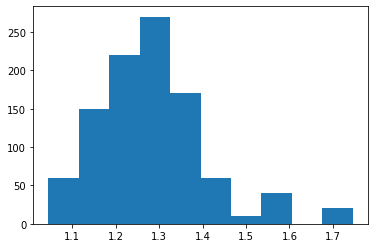

In [27]:
fig, ax = plt.subplots()
factor = 0.6
ax.hist(factor*Model.Reff[0])
print("Mean is %.2f" % np.mean(factor*Model.Reff[0]))
print("90 percent interval is %.2f and %.2f" % tuple(np.quantile(factor*Model.Reff[0], (0.05,0.95)) ))
plt.show()

In [26]:
#simulate takes arguments days, sim number, and seed
## It will return:
## cases: a n_days by 3 array where each column represents 
##         Imported, Asymptomatic and Symptomatic cases, in that order.
##        Cases are indexed in time by rows by their date of infection.
## observed_cases: a n_days by 3 array, same as cases, but only observed cases, 
##        and are indexed in time by their date of symptom onset.

N=1
p_c=1.0
DAYS = 2
Model.simulate(time_end,1,N)
    

(array([[ 0., 17., 18.],
        [ 0.,  3.,  2.],
        [ 0.,  4.,  4.],
        [ 0.,  0.,  5.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  3.],
        [ 0.,  4.,  4.],
        [ 0.,  7., 10.],
        [ 0.,  8., 11.],
        [ 0.,  8., 20.],
        [ 0.,  6., 21.],
        [ 0.,  5., 12.],
        [ 0.,  7., 12.],
        [ 0.,  5.,  8.],
        [ 0.,  5., 10.],
        [ 0.,  5., 18.],
        [ 0.,  8., 13.],
        [ 0.,  8., 12.],
        [ 0.,  3., 17.],
        [ 0.,  7.,  9.],
        [ 0.,  6., 20.],
        [ 0., 11., 13.],
        [ 0.,  5., 13.],
        [ 0.,  2., 13.],
        [ 0.,  6., 10.],
        [ 0.,  3.,  7.],
        [ 0.,  1., 10.],
        [ 0.,  2.,  0.],
        [ 0.,  2.,  5.]]),
 array([[ 0., 10.,  3.],
        [ 0.,  0.,  2.],
        [ 0.,  1., 10.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  3.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  2.],
        [ 0.,  0.,  4.]

In [22]:
# Simulation study for delay time

t_a_shape = 3/2
t_a_scale = 2

n=1000

DAYS = 3
p_c = 1
pc_100_day_N3 = []
for N in range(0, n):
    cases_array, observed_cases_array, params = Model.simulate(time_end,1,N)
    
    #v = list(x)[2]
    #v2 = v.values()
    Cases = params['Model_people']
    CasesAfter = params['cases_after']
    CasesTotal = Cases + CasesAfter

    pc_100_day_N3.append((CasesTotal))
    
    if N%100==0:
        print("sim number %i " % N)
        print("Timeline of Cases:\n", cases_array)
        print("Length of People (CasesTotal): %i " % CasesTotal)

print('Completed Days = -3 , p = 1.0')



sim number 0 
Timeline of Cases:
 [[ 0. 13. 12.]
 [ 0.  1.  5.]
 [ 0.  0.  2.]
 [ 0.  1.  4.]
 [ 0.  1.  7.]
 [ 0.  2.  1.]
 [ 0.  4.  8.]
 [ 0.  1. 10.]
 [ 0.  6. 11.]
 [ 0.  7. 18.]
 [ 0.  3. 23.]
 [ 0. 10. 20.]
 [ 0. 15. 23.]
 [ 0. 18. 23.]
 [ 0. 17. 34.]
 [ 0. 21. 33.]
 [ 0. 15. 19.]
 [ 0. 19. 35.]
 [ 0.  9. 25.]
 [ 0. 12. 41.]
 [ 0. 26. 51.]
 [ 0. 27. 80.]
 [ 0. 30. 72.]
 [ 0. 38. 81.]
 [ 0. 25. 58.]
 [ 0. 19. 46.]
 [ 0. 25. 52.]
 [ 0. 28. 42.]
 [ 0. 14. 36.]
 [ 0. 11. 36.]]
Length of People (CasesTotal): 1535 


KeyboardInterrupt: 

In [ ]:
# trace back branches

#Look at the last person 
#Model.people[len(Model.people)-1].__dict__

#Model.people[4].__dict__



Model.people[29].__dict__



In [ ]:
#Look at a person in the people dictionary
Model.people[7].__dict__



In [ ]:
#Look at the last person 
Model.people[len(Model.people)-1].__dict__

In [ ]:
# Laura
# Look at people in order
Model.people[2].__dict__

In [ ]:
# Laura
# Total number of people infected
len(Model.people)

In [ ]:
#how many offspring are in the next generation after simulation end_date
Model.cases_after

In [ ]:
#Delay distribution
fig,ax = plt.subplots(figsize=(12,9))
#x = np.random.gamma(5/2, 2, size = 10000)
x = np.random.gamma(3/2, 2, size = 10000)
print("Mean: %f.2" %np.mean(x))
print("Variance: %f.2" %np.var(x))
ax.hist(x,bins=40)
ax.set_title("Time to action distribution")
plt.show()

In [ ]:
#reproduction number for day n
#if forecast_type is R_L0, then every day has the same distribution for Reff
# which is baseline for 1st March with no social distancing in Aus.
n = 30

fig, ax = plt.subplots()

ax.hist(Model.Reff[n],bins=30)

plt.show()

In [ ]:
#Infection time distribution
fig,ax = plt.subplots(figsize=(12,9))
x = 1+np.random.gamma(3.5/0.5, 0.5, size = 10000)
print("Mean: %f.2" %np.mean(x))
print("Variance: %f.2" %np.var(x))
ax.hist(x,bins=40)
ax.set_title("Generation time distribution")
plt.show()

In [ ]:
print(np.quantile(x,0.4)) #infection time
y = 1+np.random.gamma(3/1, 1, size = 10000) #symptom time
fig, ax = plt.subplots()
ax.hist(y, bins=40)
#ax.hist(y-x,bins =40)

print(np.percentile(y-x, 40))

plt.show()

In [ ]:
#Observation time distribution
fig,ax = plt.subplots(figsize=(12,9))
y = np.random.gamma(5*5/1, 1/5, size = 10000)
y = [yi for yi in y if yi >2]
print("Mean: %f.2" %np.mean(y))
print("Variance: %f.2" %np.var(y))
ax.hist(y,bins=40)
ax.set_title("Observation time distribution")
plt.show()


In [ ]:
#Symptom onset time distribution
fig,ax = plt.subplots(figsize=(12,9))
y = np.random.gamma(5.807/0.948, 0.948, size = 10000)

print("Mean: %f.2" %np.mean(y))
print("Variance: %f.2" %np.var(y))
print("95 percent interval is %.2f to %.2f" % (np.quantile(y,0.025), np.quantile(y,0.975)) )
ax.hist(y,bins=40)
ax.set_title("Symptom time distribution")
plt.show()


In [ ]:
#Symptom onset time distribution
fig,ax = plt.subplots(figsize=(12,9))
y = np.random.gamma(5.807/0.948, 0.948, size = 10000)

print("Mean: %f.2" %np.mean(y))
print("Variance: %f.2" %np.var(y))
print("95 percent interval is %.2f to %.2f" % (np.quantile(y,0.025), np.quantile(y,0.975)) )
ax.hist(y,bins=40)
ax.set_title("Symptom time distribution")
#Symptom onset time distribution
fig,ax = plt.subplots(figsize=(12,9))
y = 2+np.random.gamma(3/1, 1, size = 10000)

print("Mean: %f.2" %np.mean(y))
print("Variance: %f.2" %np.var(y))
print("95 percent interval is %.2f to %.2f" % (np.quantile(y,0.025), np.quantile(y,0.975)) )
ax.hist(y,bins=40)
ax.set_title("Symptom time distribution")


plt.show()

In [ ]:
#Neg Binomial offspring distribution
Reff=1.4
n = 3
p = 1- Reff/(Reff+k)
fig,ax = plt.subplots(figsize=(12,9))
rv = nbinom(n, p)
x = np.arange(nbinom.ppf(0.01, n, p),
          nbinom.ppf(0.99, n, p))
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
     label='frozen pmf')

print("Mean: %f.2" % nbinom.stats(n,p)[0])
print("Variance: %f.2" %nbinom.stats(n,p)[1])

ax.set_title("Offspring distribution")
plt.show()

In [ ]:
## Check Neg Binom distribution 
k=0.1

Reff = pd.read_hdf('../data/soc_mob_R2020-06-22.h5',
            key='Reff')

R = Reff.loc[(Reff.type=='R_L')&(Reff.state=='VIC'),['date']+list(range(99))]
R = R.loc[R.date>='2020-06-15']
fig,ax = plt.subplots(figsize=(12,9))
ax.plot(R.date, 0.89*R[range(99)].median(axis=1))
num_offspring = nbinom.rvs(k, 1- 0.89*R[range(99)]/(0.89*R[range(99)] + k))

bins = np.bincount(num_offspring)

fig,ax = plt.subplots(figsize=(12,9))
ax.vlines(range(len(bins)),0, bins)

print("Mean is %.2f" %np.mean(num_offspring))
plt.show()

In [ ]:
k = 0.1
alpha_s = 0
R_L = 0.3
p = 1 - alpha_s* R_L/ (alpha_s*R_L + k)
x = nbinom.rvs(k ,p,size=100000)

#plotting
print("mean should be %.4f " % (alpha_s*R_L))
print("Mean is %.4f" % np.mean(x))
print("Variance is %.2f " %np.var(x))
fig,ax = plt.subplots()
ax.vlines(range(len(np.bincount(x))),0,np.bincount(x))
ax.set_xlim((0,15))
plt.locator_params(axis='x', nbins=4)
plt.show()

In [ ]:
## imports NT
alpha = 15
b = 22.2

p = 1 - 1/ (1 + b)
x = nbinom.rvs(alpha ,p,size=10000)

#plotting
print("Mean is %.4f" % np.mean(x))
print("Variance is %.2f " %np.var(x))
fig,ax = plt.subplots()
ax.vlines(range(len(np.bincount(x))),0,np.bincount(x))
#ax.set_xlim((0,15))
plt.locator_params(axis='x', nbins=4)
plt.show()

In [ ]:
#Posterior predictive distribution of imports
a_dict = {
            'ACT': {
                1:10,
                2:21,
                3:22,
                4:2
            },
            'NSW': {
                1: 315,
                2: 620,
                3: 799,
                4: 19,
            },
            'NT': {
                1: 4,
                2: 6,
                3: 17,
                4: 3,
            },
            'QLD': {
                1:170,
                2:268,
                3:351,
                4:14,
            },
            'SA': {
                1:44,
                2:124,
                3:125,
                4:5,
            },
            'TAS':{
                1:10,
                2:31,
                3:39,
                4:2,

            },
            'VIC': {
                1:150,
                2:158,
                3:223,
                4:22,
            },
            'WA': {
                1:78,
                2:114,
                3:255,
                4:3,
            },
        }

b_dict = {
            1: 14.2,
            2: 5.2,
            3: 26.2,
            4: 23.2
        }
        

## Check Neg Binom distribution 
a = a_dict['NSW'][2]
b = b_dict[2]
num_offspring = nbinom.rvs(a, 1- 1/(b + 1),size=1000)

bins = np.bincount(num_offspring)

fig,ax = plt.subplots(figsize=(12,9))
ax.vlines(range(len(bins)),0, bins)

print("Mean is %.2f" %np.mean(num_offspring))
plt.show()

From numpy (but not scipy), the probability density for the negative binomial distribution is

\begin{equation}
P(N ; n, p)={N+n-1 \choose n-1} p^{n}(1-p)^{N} \\
\end{equation}
where $n-1$ is the number of successes, $p$ is the probability of success, and $N+n-1$ is the number of trials. The negative binomial distribution gives the probability of $n-1$ successes and $N$ failures in $N+n-1$ trials, and success on the (N+n)th trial.

In [ ]:
alpha_i = 0.1
Reff=2.2
k = 3
p = alpha_i*Reff/(alpha_i*Reff + k)
print("Probability of a success is: %.3f" % p)
nbinomI = nbinom(k,1-p)
samples = nbinomI.rvs(size=1000)
print("mean is: %.2f" % np.mean(samples))
ax = plt.hist(samples)

plt.show()

In [ ]:
def my_nbinom(s, k, p):
    """
    my own nbinom, s= failures, k = successes, p = probability of success
    """
    
    from scipy.special import comb
    
    return comb(k+s-1,s)* p**k*(1-p)**s

pdf = []
for s in np.arange(0,10):
    pdf.append(my_nbinom(s,3 ,1-p))
    
plt.bar(np.arange(0,10),pdf)
plt.show()

In [ ]:

Reff=2.2
k = 3
p =1- Reff/(Reff + k)
print("Probability of a success is: %.3f" % p)
nbinomI = nbinom(n=k, p = p )
samples = nbinomI.rvs(size=100)
print("Mean is %.2f" %np.mean(samples))
print("Variance is %.2f" %np.var(samples))
ax = plt.hist(samples, bins=20)

plt.show()